# Example - Getting Flywheel Metadata and Image Files using the SDK

This notebook shows 3 ways to access files in Flywheel.  All of them use a data view as a source list of files.

1. Download the files to the 'Data' directory
2. Read the file image into memory directly
3. Use the file signed URL to read the file image into memory

This notebook can be downloaded and run as-is within the Flywheel Notebook environment without any package dependencies.

It uses the MedNIST data set, which can be ingested using this tutorial notebook: [MedNIST dataset ingestion to Flywheel](https://gitlab.com/flywheel-io/scientific-solutions/tutorials/notebooks/MedNIST/-/blob/main/1_ingest.ipynb?ref_type=heads)

The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.If you use the MedNIST dataset, please acknowledge the source.


### Preconfigured flywheel_client

The `fw` variable is pre-initialized with an ephemeral api key with your user credentials, so you don't need to provide.  Below is an example usage:

In [1]:
fw.get_current_user().id

'username@gmail.com'

### Preloaded project object

The environment is also preloaded with flywheel project info from the flywheel project the workspace is in.  This exists under `fw.workspace_project` and `fw_project`

In [2]:
project = fw_project

In [3]:
project.label

'MedNIST'

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

In [5]:
data_path = Path('Data')

## Use Data Views to get the relevant metadata, list of files and their IDs into a data frame.

We will use the data frame to manage the list of files

For creating data views in the SDK see [Flywheel SDK docs]( https://flywheel-io.gitlab.io/product/backend/sdk/branches/master/python/getting_started_new.html#dataview-functionality)

In [6]:
cols = [{'src': "subject.mlset", 'dst': 'mlset'}, 
        {'src': 'acquisition.info.label', 'dst': 'label'},
        {'src':  'file.name', 'dst': 'filename'},
        {'src':'file.file_id', 'dst':'file_id'}]

In [7]:
builder = flywheel.ViewBuilder(label='My Dataset',
                               container='acquisition',
                               filename='*.*', # Needed for file metadata
                               match='all',
                               process_files=False,
                               include_ids=False,
                               include_labels=False,
                               sort=False,
                               error_column=False)

In [8]:
# Add the columns described above
for c in cols:
    builder.column(**c)

In [9]:
view = builder.build()

In [10]:
df = fw.read_view_dataframe(view, project.id)

In [11]:
df

mlset    label         filename                   file_id
0     Testing  ChestCT      004626.jpeg  649e0ae83cc5f328e949804b
1     Testing  ChestCT  004626_norm.png  649e0ae83cc5f328e9498071
2    Training      CXR      006852.jpeg  649e0ae83cc5f328e9498025
3    Training      CXR  006852_norm.png  649e0ae83cc5f328e9498010
4    Training      CXR      003357.jpeg  649e0ae83cc5f328e9498093
..        ...      ...              ...                       ...
195  Training      CXR  002322_norm.png  649e0ae93cc5f328e94980d0
196  Training  ChestCT      009993.jpeg  649e0ae93cc5f328e94980b1
197  Training  ChestCT  009993_norm.png  649e0ae83cc5f328e949800b
198  Training   HeadCT      004130.jpeg  649e0ae83cc5f328e9498092
199  Training   HeadCT  004130_norm.png  649e0ae83cc5f328e9498091

[200 rows x 4 columns]

## Download the files into the Data directory
The `Data` directory can be used as temporary storage for large data sets.  When using 'Publish to Flywheel' it will not be transferred to Flywheel.

In [12]:
def download_files(file_df, destination, ml_folders = True, n_jobs=8):
    def download_file( destination, index, row):
        file_container = fw.get_file(row['file_id'])
        #acq = fw.get(file_container.parents.acquisition)
        if ml_folders:
            dest_file = destination/row['mlset']/file_container.name
        else:
            dest_file = destination/file_container.name
        #acq.download_file(file_container.name, dest_file)
        file_container.download(dest_file)


    # Use multiple threads to speed up since its IO bound
    Parallel(n_jobs,prefer='threads')(
        delayed(download_file)(destination, index, file_df.loc[index])
        for index in tqdm(file_df.index));

In [13]:
download_files(df,Path('Data'),ml_folders= False)

  0%|          | 0/200 [00:00<?, ?it/s]

#### Read a sample of the images in the Data directory and display

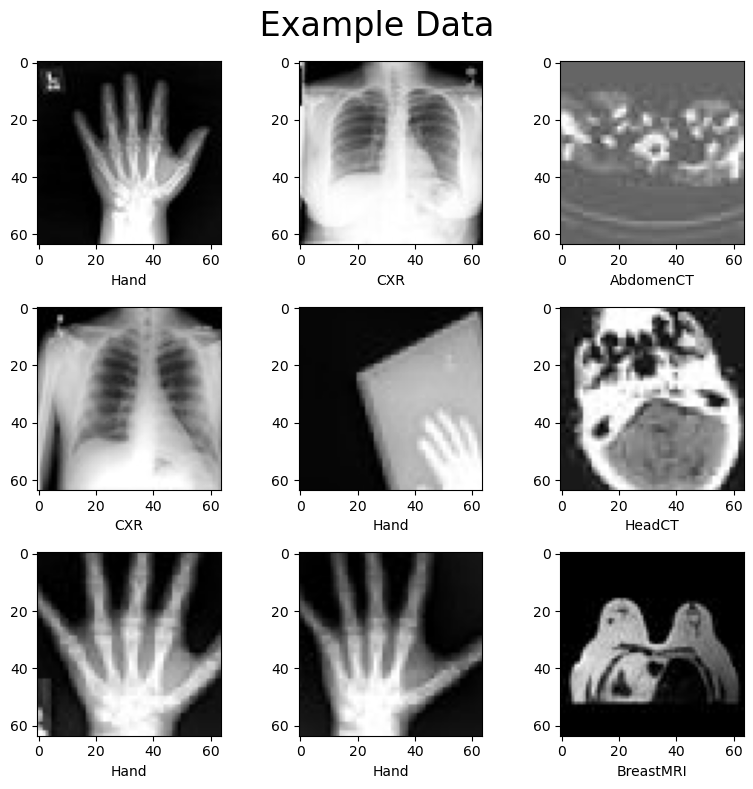

In [14]:
fig,ax = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle(' Example Data ', fontsize=24)
for i, k in enumerate(np.random.randint(len(df), size=9)):
    im = Image.open(data_path/df['filename'][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(str(df['label'][k]))
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()

plt.show()

## Read files to memory from Flywheel database

In [15]:
image_list = []

In [16]:
for index in tqdm(df.index):
    row = df.loc[index]
    file_container = fw.get_file(row['file_id'])
    bytes_data = file_container.read()
    f = BytesIO(bytes_data)
    img = Image.open(f)
    image_list.append(img)

  0%|          | 0/200 [00:00<?, ?it/s]

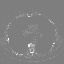

In [17]:
image_list[0]

## Use the signed URL of the image to download

In [18]:
file_container = fw.get_file(df['file_id'][1])

In [19]:
image_url = file_container.url()
print(image_url)

https://ml-demo.dev.flywheel.io:443/api/acquisitions/649e0ae83cc5f328e9497fa7/files/004626_norm.png?ticket=709def16-cd91-4840-8644-163f2e2a8659


In [20]:
import requests

bytes_data = requests.get(image_url).content
f = BytesIO(bytes_data)
img = Image.open(f)

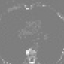

In [21]:
img